## Decision Trees and Random Forests

Random forests are an example of an *ensemble* method, meaning that it relies on aggregating the results of an ensemble of simpler estimators.

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (16,8)

## Decision Trees

Random forests are an example of an *ensemble learner* built on decision trees.

Decision trees are extremely intuitive ways to classify or label objects: simply ask a series of questions designed to narrow down on the classification.

For example, if you wanted to build a decision tree to classify an animal:

[0, 1, 0, 1]

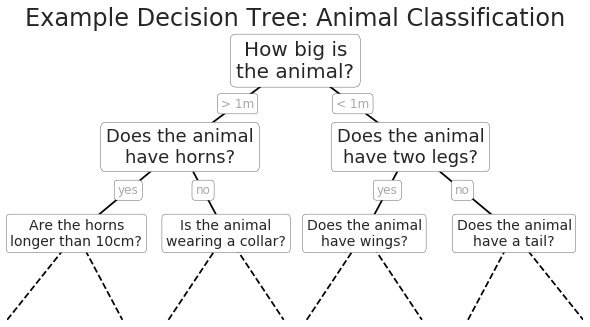

In [7]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
ax.set_title('Example Decision Tree: Animal Classification', size=24)

def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])


The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.


The trick, comes in __deciding which questions to ask at each step__.


In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups __using a cutoff value within one of the features.__


### Creating a decision tree

Consider the following two-dimensional data, which has one of four class labels:

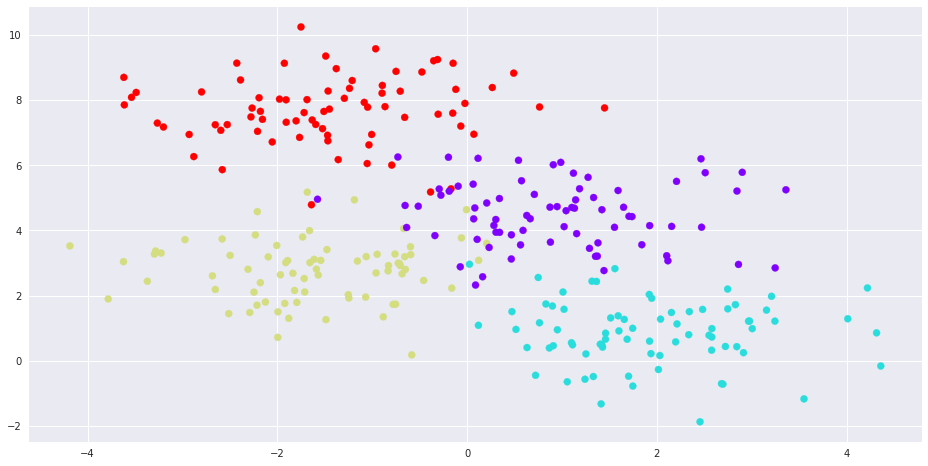

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to __some quantitative criterion__, and at each level assign the label of the new region according to a majority vote of points within it.



In [33]:
def visualize(model, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis')

    ax.set(xlim=xlim, ylim=ylim)

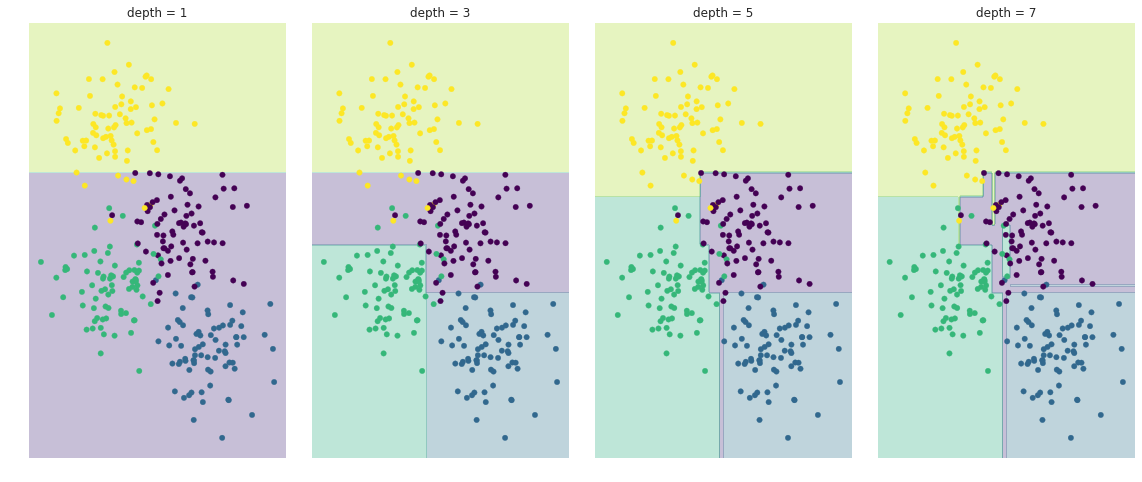

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
        
fig, ax = plt.subplots(1, 4)
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, 8, 2)):
    model = DecisionTreeClassifier(max_depth=depth) # if not specified, then the model would fit the most appropriate depth automatically
    visualize(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

### Decision trees and over-fitting

It is very easy to go too deep in the tree:

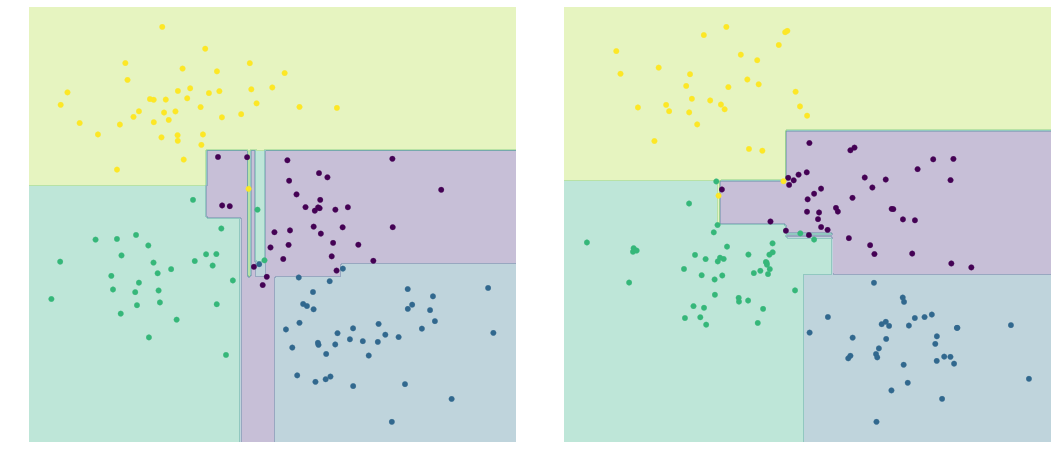

In [38]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

## Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.


Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.


An ensemble of randomized decision trees is __random forest__.


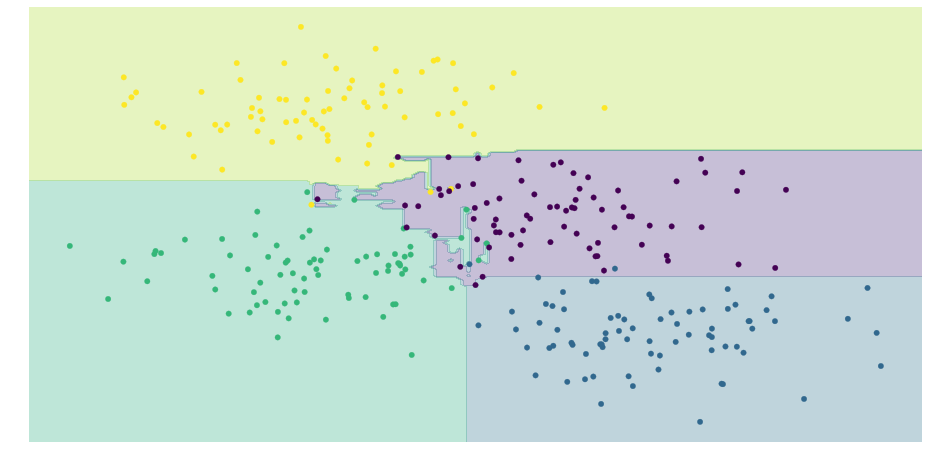

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize(bag, X, y)

__In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.__

In practice, decision trees are more effectively randomized by __injecting some stochasticity in how the splits are chosen__: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.


For example, when determining which feature to split on, the randomized tree might select from among the top several features.

more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.


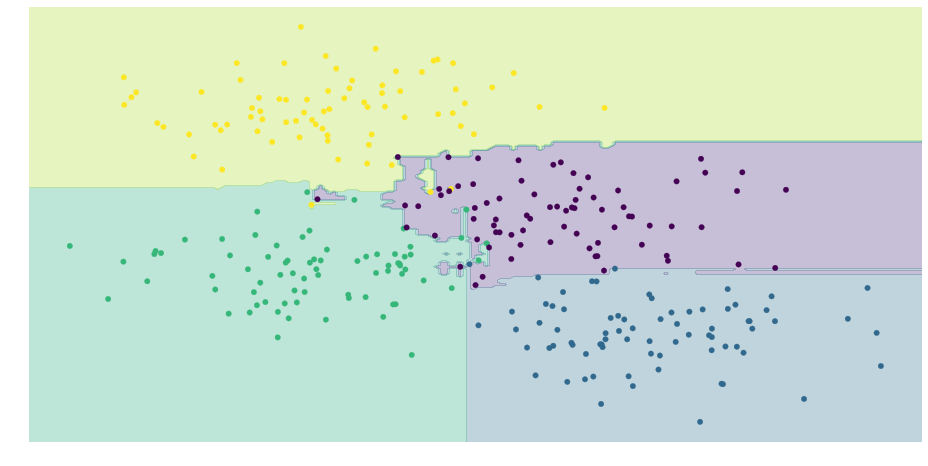

In [41]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression


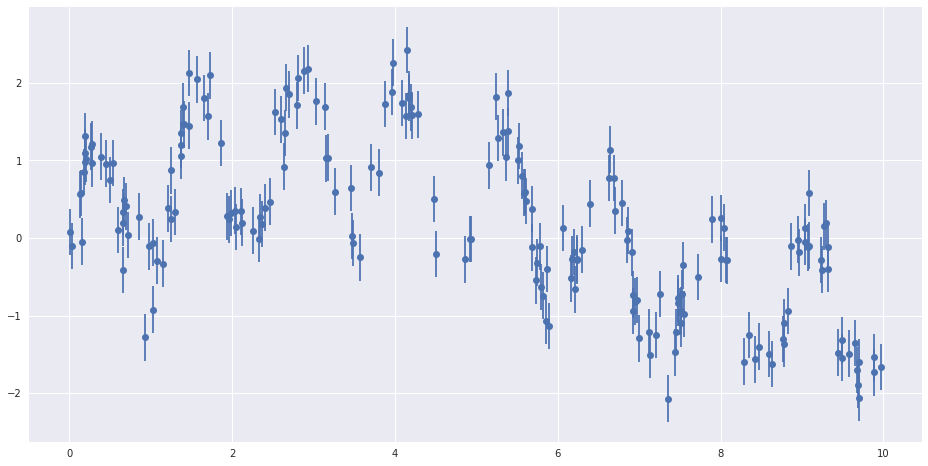

In [42]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best fit curve as follows:

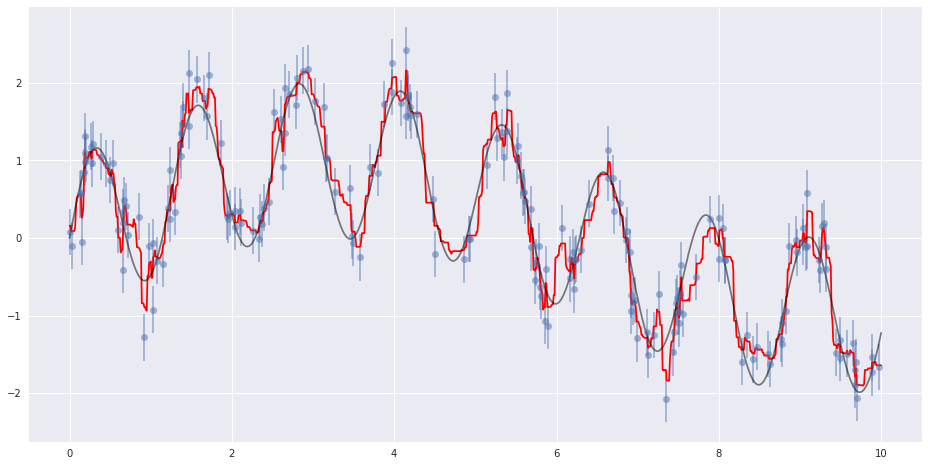

In [53]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0) # without adding noise

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.

- Note: the non-parametric random forest model is flexible enough to fit the multi-period data

## Example: Random Forest for Classifying Faces


In [79]:
# from sklearn.datasets import load_digits
# digits = load_digits()
# digits.keys()
import numpy as np
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
np.unique(faces.target)
faces.target.shape

(1348,)

In [98]:
["{} images in class {}".format(faces.target[faces.target==i].size, i) for i in range(len(np.unique(faces.target_names)))]

['77 images in class 0',
 '236 images in class 1',
 '121 images in class 2',
 '530 images in class 3',
 '109 images in class 4',
 '71 images in class 5',
 '60 images in class 6',
 '144 images in class 7']

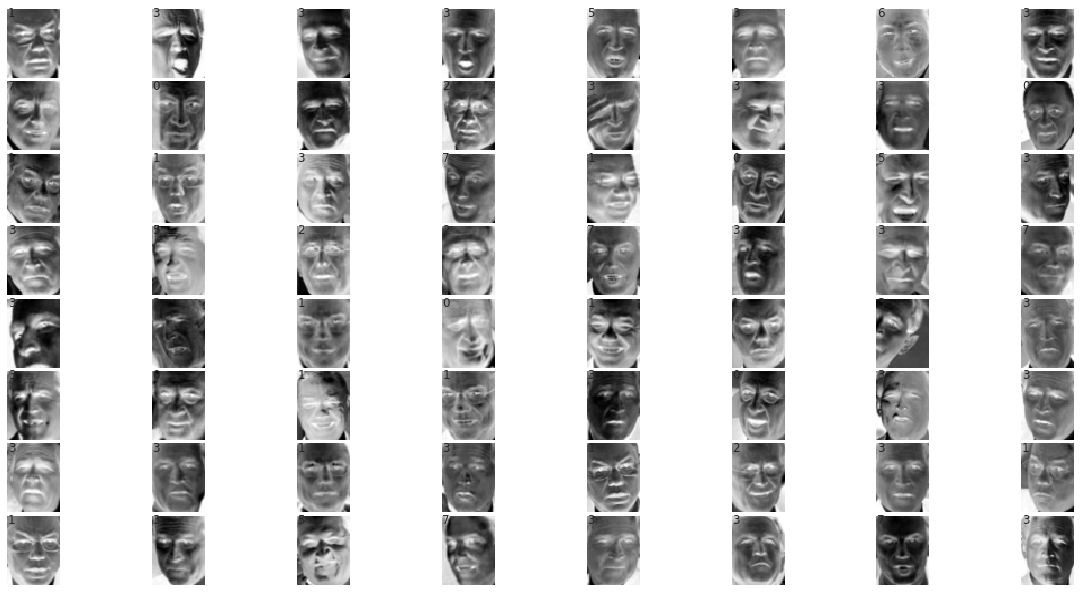

In [75]:
# set up the figure
fig = plt.figure() 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    ax.text(0, 7, str(faces.target[i]))

In [80]:
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [81]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       0.38      1.00      0.55         6
          1       0.79      0.80      0.79        60
          2       0.26      1.00      0.41         9
          3       0.98      0.55      0.70       223
          4       0.10      0.75      0.18         4
          5       0.68      0.87      0.76        15
          6       0.47      1.00      0.64         8
          7       0.23      0.67      0.34        12

avg / total       0.85      0.64      0.69       337



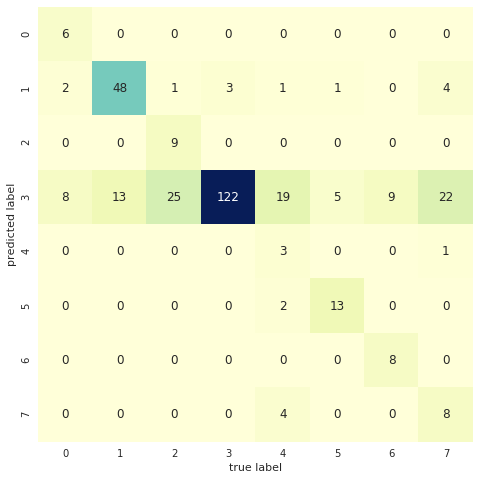

In [82]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
plt.xlabel('true label')
plt.ylabel('predicted label');

## Random Forests Pros and Cons

Pros:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, __because the individual trees are entirely independent entities.__
- The multiple trees allow for a probabilistic classification: __a majority vote among estimators gives an estimate of the probability__ (accessed in Scikit-Learn with the ``predict_proba()`` method).
- The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

Cons:

A primary disadvantage of random forests is that the results are not easily interpretable (__basically a blackbox__)